# Article Segmentation

Article Segmentation is a model created using Deep Learning and using Natural Language Processing(NLP) technique.
I have used bert model imported using tensorflow hub and preprocessing layer using tensorflow hub.

This project was made by working through the 2017 paper[*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).


In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what the files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# we will start with the 20k dataset with numbers reolaced by @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

After we get some text data, we have to visualize some data to understand it better and know what we are working with.

Let's create a finction first to read all of the lines of a target text file.

In [5]:
# create a function to read the lines of a document
def get_lines(filename):
  """
  reads filename( a text filename) and returns the lines of text as a list.

  Args:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes filename, reads its contents and sort through each line, extracting
  things like the target label, the text of the sentence, how many sentences
  are in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_line = "" # create an empty abstract and store the line between the
  # abstract id and the empty line(\n) before the next abstract id.
  abstract_samples = [] # create an emppty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if it is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see it line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data= {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get the text in lowercase
        line_data["line_number"] = abstract_line_number # what number line does the line appear in
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there
        abstract_samples.append(line_data) # add line data to the abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")# dev i  another term for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 430 ms, sys: 82.6 ms, total: 512 ms
Wall time: 552 ms


In [10]:
# check the first abstract of our training data
train_samples[:6]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
# Combining the total lines and line number into a new feature!
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)
test_df['line_number_total'] = test_df['line_number'].astype(str) + '_of_' + test_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [14]:
# Perform one hot encoding on the train and transform the validation dataframe
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))
test_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(test_df['line_number_total'] , axis= 1))

# Checking the shapes
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [15]:
from scipy.sparse import csr_matrix

In [16]:
# Converting the sparse object to array
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()
test_line_number_total_encoded = test_line_number_total_encoded.toarray()

In [17]:
# Converting the datatype to int
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)
test_line_number_total_encoded = tf.cast(test_line_number_total_encoded , dtype= tf.int32)


In [18]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [19]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [20]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

## Make numeric labels (ML models require numeric labels)

In [21]:
# One hot encode labels to turn them into numbers
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
# sparse=True returns sparse matrix which is not supported by tensorflow functions
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

# check what trainnig abels look like
train_labels_encoded[:20]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4])

In [23]:
#!pip install tensorflow_text

In [24]:
# Loading in the both encoder and the preprocessing models
import tensorflow_text as text
import tensorflow_hub as hub


preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' ,
                                     trainable = False , name = 'pubmed_bert_preprocessor')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2' ,
                            trainable = False ,
                            name = 'bert_model_layer')

In [141]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Building a tribrid embeddding model

1. Creating a token-level model
2. Creating a char-level model
3. Creating a model for "line_number_total" feature
4. Combining the outputs of 1 and 2 using `tf.keras.layers.Concatenate`
5. Combining the outputs of 3, 4 using the `tf.keras.layers.Concatenate`
6. Creating an output layer to accept the tribrid embedding and output label probabilities

In [28]:
# Buidling the tribid model using the functional api

input_token = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_token = preprocessing_layer(input_token)
bert_embedding_char =bert_layer(bert_inputs_token)
output_token = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
token_model = tf.keras.Model(input_token , output_token)

input_char = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char =bert_layer(bert_inputs_char)
output_char = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
char_model = tf.keras.Model(input_char , output_char)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output ,
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output ,
                                                    combined_embeddings])

# Adding a dense + dropout and creating our output layer
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128 , activation='relu')(dropout)
output_layer = layers.Dense(5 , activation='softmax')(x)

# Packing into a model
model = tf.keras.Model(inputs = [token_model.input ,
                                        char_model.input ,
                                        total_line_number_model.input] ,
                              outputs = output_layer)

In [140]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 pubmed_bert_preprocessor (  {'input_mask': (None, 128)   0         ['input_1[0][0]',             
 KerasLayer)                 , 'input_word_ids': (None,              'input_2[0][0]']             
                              128),                                                               
                              'input_type_ids': (None,                                      

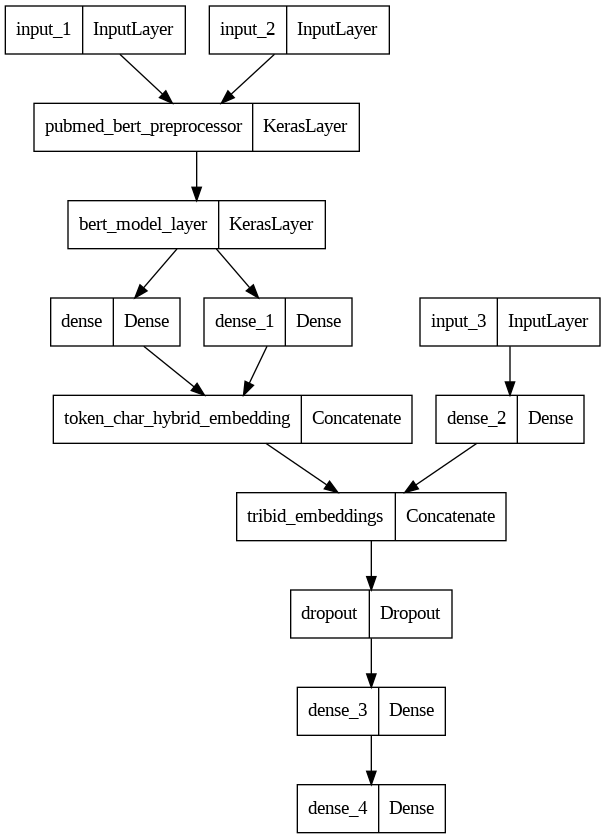

In [139]:
from keras.utils import plot_model
plot_model(model)

In [31]:

# Creating the callbacks
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath ,
                                                               save_weights_only = True ,
                                                               save_best_only = True  ,
                                                               save_freq = 'epoch' ,
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' ,
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
                metrics=["accuracy"])

### Creating tribrid datasets using tf.data and creating batches

In [33]:

# Making the performant datasets for our tribid model
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars ,
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)
#
val_data = tf.data.Dataset.from_tensor_slices((val_sentences ,
                                               val_chars ,
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
##
test_data = tf.data.Dataset.from_tensor_slices((test_sentences ,
                                               test_chars ,
                                               test_line_number_total_encoded))
# Zipping the data and labels
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))

# Applying batch and prefetching
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [35]:
# fitting the model
model_history = model.fit(train_dataset,
                          steps_per_epoch=int(0.5*len(train_dataset)),
                          epochs=10,
                          validation_data=val_dataset,
                          validation_steps=int(0.5*len(val_dataset)),
                          callbacks=[early_stopping , model_checkpoint_callback])

Epoch 1/10
1407/1407 [==============================] - 2578s 2s/step - loss: 0.5033 - accuracy: 0.8235 - val_loss: 0.2998 - val_accuracy: 0.8859
Epoch 2/10
1407/1407 [==============================] - 2551s 2s/step - loss: 0.3585 - accuracy: 0.8712 - val_loss: 0.2708 - val_accuracy: 0.9010
Epoch 3/10


1407/1407 [==============================] - 382s 272ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.2708 - val_accuracy: 0.9010


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# making predictions with the char token pos model
model_pred_probs = model.predict(val_dataset, verbose=1)
model_pred_probs

473/473 [==============================] - 740s 2s/step


array([[7.18230367e-01, 6.57402873e-02, 3.86604690e-03, 2.02010572e-01,
        1.01527330e-02],
       [7.31948137e-01, 5.45203267e-03, 9.03157145e-03, 2.44662851e-01,
        8.90542567e-03],
       [5.35368443e-01, 5.04762772e-03, 4.11980227e-02, 4.15922731e-01,
        2.46313494e-03],
       ...,
       [8.04993192e-08, 1.31407799e-03, 1.73234774e-04, 1.57511071e-08,
        9.98512566e-01],
       [1.07864405e-04, 9.69490528e-01, 3.83512015e-05, 9.77886157e-06,
        3.03536113e-02],
       [5.46898581e-02, 9.32116628e-01, 5.69477677e-03, 2.22884817e-03,
        5.26983012e-03]], dtype=float32)

In [38]:
# convert the pred probs into preds
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [39]:
model_results = calculate_results(val_labels_encoded, model_preds)
model_results

{'accuracy': 90.09334039454522,
 'precision': 0.9003798720435408,
 'recall': 0.9009334039454522,
 'f1': 0.8989918625112605}

In [40]:
# save the model
model.save("/content/drive/MyDrive/skimlit_tribrid_model")

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

In [70]:
def split_abstract_into_sentences(abstract):
  """

  Takes in an abstract

  Returns:
  --------
  list of sentences
  """
  sentences = sent_tokenize(abstract)
  return sentences

In [42]:
def add_line_numbers(sentences):
  """
  takes in list of sentences

  Returns:
  --------
  list of sentences with line numbers
  """
  sentences_with_line_numbers = []
  for line_number, sentence in enumerate(sentences, start=0):
      sentences_with_line_numbers.append((line_number, sentence))
  return sentences_with_line_numbers

In [43]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [135]:
from keras.src.backend import dtype
def visualize_pred_sequence_labels(abstract, model, label_encoder):
  """
  Arguments:
  -----------
    abstract: bstarct that we want to work on,
    model: model which will be used to label the abstract
    label_encoder: label_encoder which is used to encode the classes

  Returns:
  ---------
    Prints out the predicted label and the corresponding sequence Text.

  """
  sentence_list = split_abstract_into_sentences(abstract)
  sentence_with_line_number = add_line_numbers(sentence_list)
  total_lines = len(sentence_with_line_number)

  data=[]
  for line_number, sentences in sentence_with_line_number:
    data.append({
        "text": sentences,
        "line_number": line_number,
        "total_lines": total_lines
    })
  df = pd.DataFrame(data)

  # convert abstract sentences(text) lines into lists
  sentences = df["text"].tolist()

  # Split sequence-level data splits into character-level data splits
  chars = [split_chars(sentence) for sentence in sentences]

  df['line_number_total'] = df['line_number'].astype(str) + '_of_' + df['total_lines'].astype(str)
  # Fitting on the training dataframe
  line_number_total_encoded = one_hot_encoder.fit(np.expand_dims(df['line_number_total'], axis=1))
  line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(df['line_number_total'], axis=1))
  #line_number_total_encoded = line_number_total_encoded.toarray()
  # Converting the datatype to int
  line_number_total_encoded = tf.cast(line_number_total_encoded , dtype= tf.int32)

  expanded_data = np.zeros((line_number_total_encoded.shape[0], 460), dtype='int32')

  for i in range(line_number_total_encoded.shape[0]):
      for j in range(line_number_total_encoded.shape[1]):
          expanded_data[i, j] = line_number_total_encoded[i, j]
  for i in range(line_number_total_encoded.shape[0]):
      for j in range(line_number_total_encoded.shape[1] + 1, 460):
          expanded_data[i, j] = 0
  line_number_total_encoded = expanded_data
  pred_probs = model.predict(x = (tf.constant(sentences),
                                  tf.constant(chars),
                                  line_number_total_encoded))

  preds = tf.argmax(pred_probs, axis=1)

  pred_classes = [label_encoder.classes_[i] for i in preds]

  for i, line in enumerate(sentences):
    print(f"{pred_classes[i]}: {line}\n")

In [137]:
abstract = "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."
#abstract = "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients."

In [138]:
visualize_pred_sequence_labels(abstract, model, label_encoder)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 192ms/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS: Participants were randomly assigned to treatment or wait-list conditions.

OBJECTIVE: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

BACKGROUND: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS: Standardized effect size estimates were primarily in the medium and large ranges